In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([1, 2, 3], [1, 4, 9])
plt.title("Тестовый график")
plt.show()

Датасет

In [197]:
import os
from torch.utils.data import Dataset
import torch
import random
import cv2
from PIL import Image, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, models
import time
import tracemalloc

class CustomImageDataset(Dataset):
    """Кастомный датасет для работы с папками классов"""
    
    def __init__(self, root_dir, transform=None, target_size=(224, 224)):
        """
        Args:
            root_dir (str): Путь к папке с классами
            transform: Аугментации для изображений
            target_size (tuple): Размер для ресайза изображений
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        
        # Получаем список классов (папок)
        self.classes = sorted([d for d in os.listdir(root_dir) 
                              if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Собираем все пути к изображениям
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    img_path = os.path.join(class_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Загружаем изображение
        image = Image.open(img_path).convert('RGB')
        
        # Ресайзим изображение
        image = image.resize(self.target_size, Image.Resampling.LANCZOS)
        
        # Применяем аугментации
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_class_names(self):
        """Возвращает список имен классов"""
        return self.classes 

Дополнительные аугментации на изображение

In [3]:
class AddGaussianNoise:
    """Добавляет гауссов шум к изображению."""
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

class RandomErasingCustom:
    """Случайно затирает прямоугольную область изображения."""
    def __init__(self, p=0.5, scale=(0.02, 0.2)):
        self.p = p
        self.scale = scale
    def __call__(self, img):
        if random.random() > self.p:
            return img
        c, h, w = img.shape
        area = h * w
        erase_area = random.uniform(*self.scale) * area
        erase_w = int(np.sqrt(erase_area))
        erase_h = int(erase_area // erase_w)
        x = random.randint(0, w - erase_w)
        y = random.randint(0, h - erase_h)
        img[:, y:y+erase_h, x:x+erase_w] = 0
        return img

class CutOut:
    """Вырезает случайную прямоугольную область из изображения."""
    def __init__(self, p=0.5, size=(16, 16)):
        self.p = p
        self.size = size
    def __call__(self, img):
        if random.random() > self.p:
            return img
        c, h, w = img.shape
        cut_h, cut_w = self.size
        x = random.randint(0, w - cut_w)
        y = random.randint(0, h - cut_h)
        img[:, y:y+cut_h, x:x+cut_w] = 0
        return img

class Solarize:
    """Инвертирует пиксели выше порога."""
    def __init__(self, threshold=128):
        self.threshold = threshold
    def __call__(self, img):
        img_np = img.numpy()
        mask = img_np > self.threshold / 255.0
        img_np[mask] = 1.0 - img_np[mask]
        return torch.from_numpy(img_np)

class Posterize:
    """Уменьшает количество бит на канал."""
    def __init__(self, bits=4):
        self.bits = bits
    def __call__(self, img):
        img_np = img.numpy()
        factor = 2 ** (8 - self.bits)
        img_np = (img_np * 255).astype(np.uint8)
        img_np = (img_np // factor) * factor
        return torch.from_numpy(img_np.astype(np.float32) / 255.0)

class AutoContrast:
    """Автоматически улучшает контраст изображения."""
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        if random.random() > self.p:
            return img
        img_np = img.numpy().transpose(1, 2, 0)
        img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
        img_pil = ImageOps.autocontrast(img_pil)
        img_np = np.array(img_pil).astype(np.float32) / 255.0
        return torch.from_numpy(img_np.transpose(2, 0, 1))

class ElasticTransform:
    """Эластичная деформация изображения."""
    def __init__(self, p=0.5, alpha=1, sigma=50):
        self.p = p
        self.alpha = alpha
        self.sigma = sigma
    def __call__(self, img):
        if random.random() > self.p:
            return img
        img_np = img.numpy().transpose(1, 2, 0)
        h, w = img_np.shape[:2]
        
        # Создаем случайные смещения
        dx = np.random.randn(h, w) * self.alpha
        dy = np.random.randn(h, w) * self.alpha
        
        # Сглаживаем смещения
        dx = cv2.GaussianBlur(dx, (0, 0), self.sigma)
        dy = cv2.GaussianBlur(dy, (0, 0), self.sigma)
        
        # Применяем деформацию
        x, y = np.meshgrid(np.arange(w), np.arange(h))
        x = x + dx
        y = y + dy
        
        # Нормализуем координаты
        x = np.clip(x, 0, w - 1)
        y = np.clip(y, 0, h - 1)
        
        # Применяем трансформацию
        img_deformed = cv2.remap(img_np, x.astype(np.float32), y.astype(np.float32), 
                                cv2.INTER_LINEAR)
        return torch.from_numpy(img_deformed.transpose(2, 0, 1))

class MixUp:
    """Смешивает два изображения."""
    def __init__(self, p=0.5, alpha=0.2):
        self.p = p
        self.alpha = alpha
    def __call__(self, img1, img2):
        if random.random() > self.p:
            return img1
        lam = np.random.beta(self.alpha, self.alpha)
        return lam * img1 + (1 - lam) * img2 

Отображение

In [17]:
def show_images(images, labels=None, nrow=8, title=None, size=128):
    """Визуализирует батч изображений."""
    images = images[:nrow]
    
    # Увеличиваем изображения до 128x128 для лучшей видимости
    resize_transform = transforms.Resize((size, size), antialias=True)
    images_resized = [resize_transform(img) for img in images]
    
    # Создаем сетку изображений
    fig, axes = plt.subplots(1, nrow, figsize=(nrow*2, 2))
    if nrow == 1:
        axes = [axes]
    
    for i, img in enumerate(images_resized):
        img_np = img.numpy().transpose(1, 2, 0)
        # Нормализуем для отображения
        img_np = np.clip(img_np, 0, 1)
        axes[i].imshow(img_np)
        axes[i].axis('off')
        if labels is not None:
            axes[i].set_title(f'Label: {labels[i]}')
    
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def show_single_augmentation(original_img, augmented_img, title="Аугментация"):
    """Визуализирует оригинальное и аугментированное изображение рядом."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # Увеличиваем изображения
    resize_transform = transforms.Resize((128, 128), antialias=True)
    orig_resized = resize_transform(original_img)
    aug_resized = resize_transform(augmented_img)
    
    # Оригинальное изображение
    orig_np = orig_resized.numpy().transpose(1, 2, 0)
    orig_np = np.clip(orig_np, 0, 1)
    ax1.imshow(orig_np)
    ax1.set_title("Оригинал")
    ax1.axis('off')
    
    # Аугментированное изображение
    aug_np = aug_resized.numpy().transpose(1, 2, 0)
    aug_np = np.clip(aug_np, 0, 1)
    ax2.imshow(aug_np)
    ax2.set_title(title)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def show_multiple_augmentations(original_img, augmented_imgs, titles):
    """Визуализирует оригинальное изображение и несколько аугментаций."""
    n_augs = len(augmented_imgs)
    fig, axes = plt.subplots(1, n_augs + 1, figsize=((n_augs + 1) * 2, 2))
    
    # Увеличиваем изображения
    resize_transform = transforms.Resize((128, 128), antialias=True)
    orig_resized = resize_transform(original_img)
    
    # Оригинальное изображение
    orig_np = orig_resized.numpy().transpose(1, 2, 0)
    orig_np = np.clip(orig_np, 0, 1)
    axes[0].imshow(orig_np)
    axes[0].set_title("Оригинал")
    axes[0].axis('off')
    
    # Аугментированные изображения
    for i, (aug_img, title) in enumerate(zip(augmented_imgs, titles)):
        aug_resized = resize_transform(aug_img)
        aug_np = aug_resized.numpy().transpose(1, 2, 0)
        aug_np = np.clip(aug_np, 0, 1)
        axes[i + 1].imshow(aug_np)
        axes[i + 1].set_title(title)
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show() 
    

    


Обучение (ПРИМЕР)

Оригинальное изображение, класс: Гароу

=== Демонстрация отдельных аугментаций ===


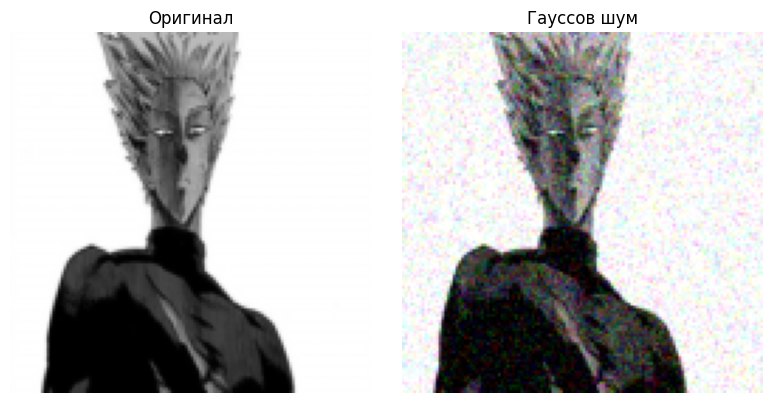

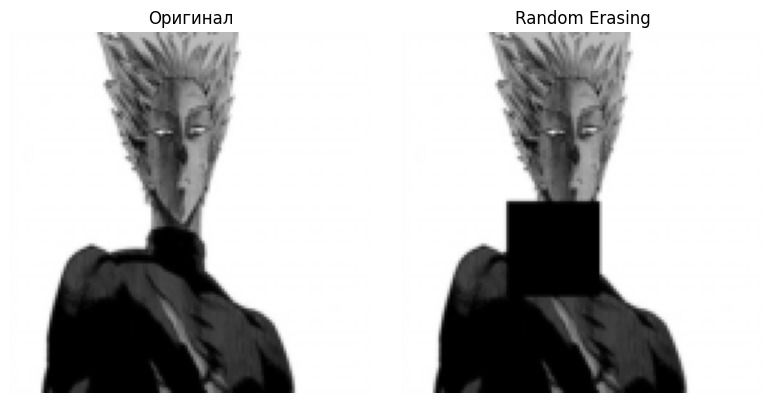

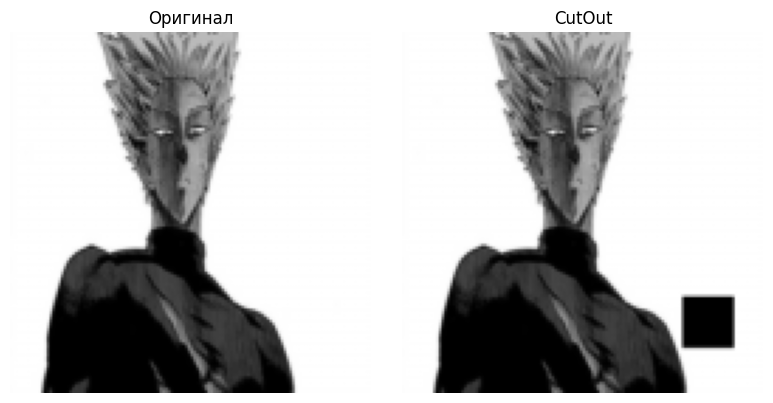

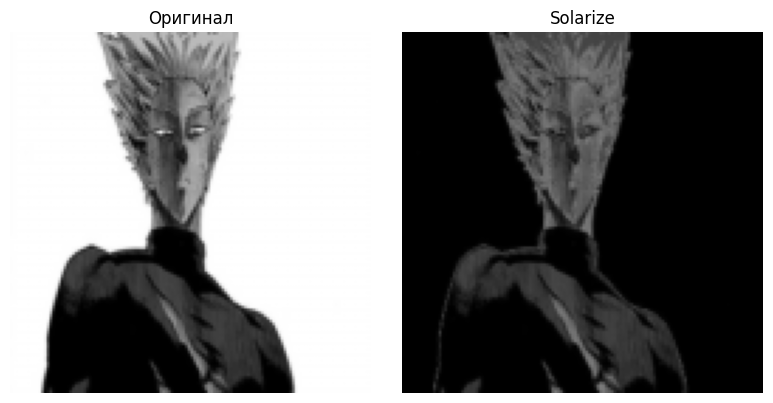

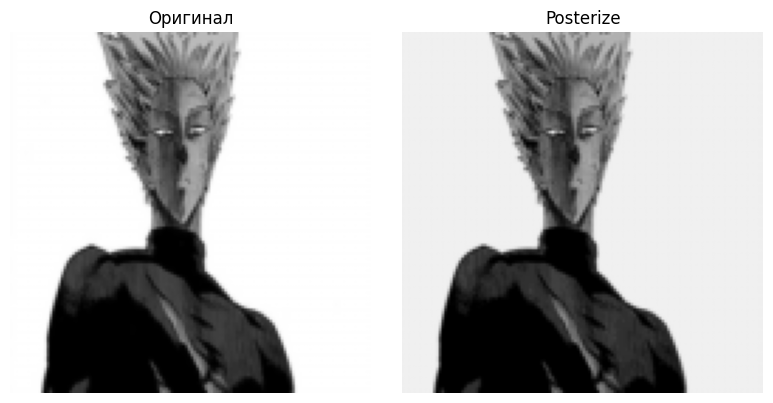

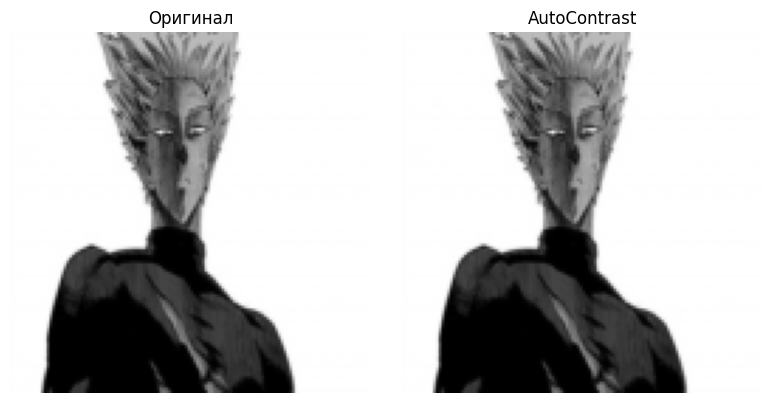

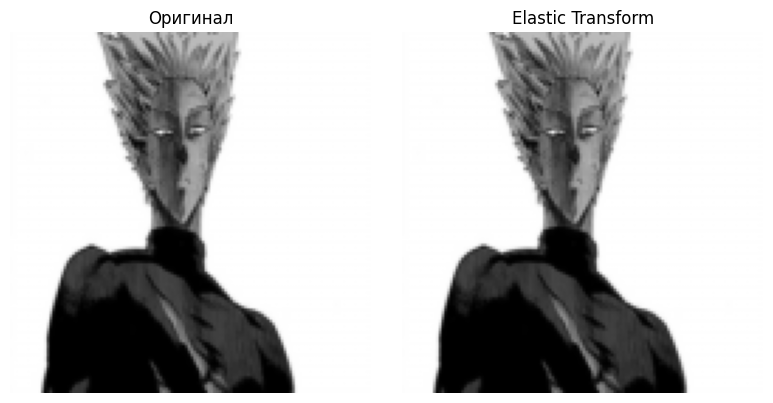


=== Стандартные аугментации torchvision ===


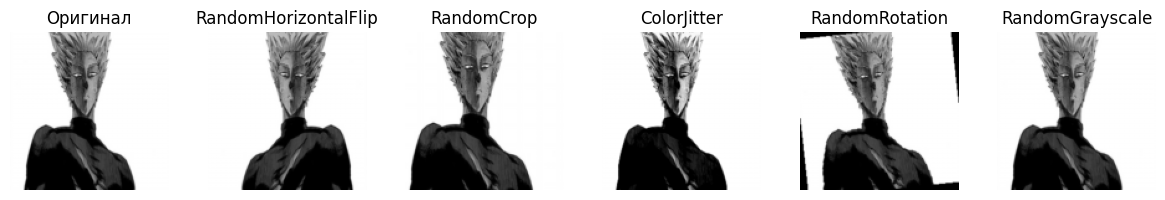


=== Комбинированные аугментации ===


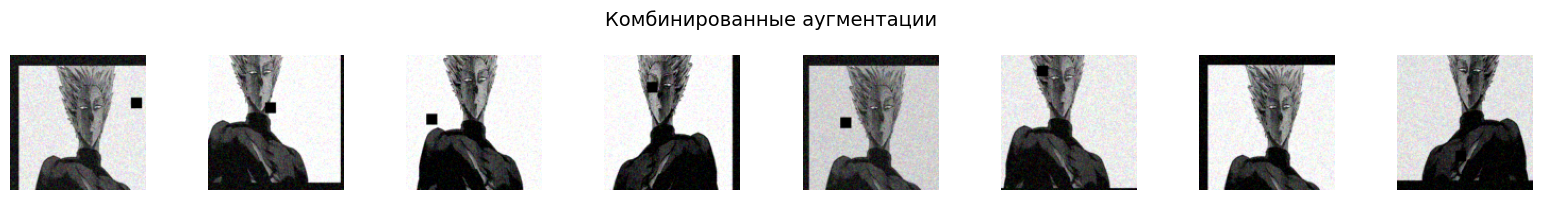

In [32]:
# Загрузка датасета без аугментаций
root = 'D:\\УЧЕБА_УРФУ\\Программирование\\4_семестр\\Практика\\data\\dataset\\train'
dataset = CustomImageDataset(root, transform=None, target_size=(224, 224))

# Берем одно изображение для демонстрации
original_img, label = dataset[0]
class_names = dataset.get_class_names()
print(f"Оригинальное изображение, класс: {class_names[label]}")

# Демонстрация каждой аугментации отдельно
print("\n=== Демонстрация отдельных аугментаций ===")

# 1. Гауссов шум
noise_aug = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.2)
])
to_tensor = transforms.ToTensor()
original_tensor = to_tensor(original_img)



noise_img = noise_aug(original_img)
show_single_augmentation(original_tensor, noise_img, "Гауссов шум")

# 2. Random Erasing
erase_aug = transforms.Compose([
    transforms.ToTensor(),
    RandomErasingCustom(p=1.0)
])
erase_img = erase_aug(original_img)
show_single_augmentation(original_tensor, erase_img, "Random Erasing")

# 3. CutOut
cutout_aug = transforms.Compose([
    transforms.ToTensor(),
    CutOut(p=1.0, size=(32, 32))
])
cutout_img = cutout_aug(original_img)
show_single_augmentation(original_tensor, cutout_img, "CutOut")

# 4. Solarize
solarize_aug = transforms.Compose([
    transforms.ToTensor(),
    Solarize(threshold=128)
])
solarize_img = solarize_aug(original_img)
show_single_augmentation(original_tensor, solarize_img, "Solarize")

# 5. Posterize
posterize_aug = transforms.Compose([
    transforms.ToTensor(),
    Posterize(bits=4)
])
posterize_img = posterize_aug(original_img)
show_single_augmentation(original_tensor, posterize_img, "Posterize")

# 6. AutoContrast
autocontrast_aug = transforms.Compose([
    transforms.ToTensor(),
    AutoContrast(p=1.0)
])
autocontrast_img = autocontrast_aug(original_img)
show_single_augmentation(original_tensor, autocontrast_img, "AutoContrast")

# 7. Elastic Transform
elastic_aug = transforms.Compose([
    transforms.ToTensor(),
    ElasticTransform(p=1.0, alpha=1, sigma=50)
])
elastic_img = elastic_aug(original_img)
show_single_augmentation(original_tensor, elastic_img, "Elastic Transform")

# Демонстрация стандартных аугментаций torchvision
print("\n=== Стандартные аугментации torchvision ===")

standard_augs = [
    ("RandomHorizontalFlip", transforms.RandomHorizontalFlip(p=1.0)),
    ("RandomCrop", transforms.RandomCrop(200, padding=20)),
    ("ColorJitter", transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)),
    ("RandomRotation", transforms.RandomRotation(degrees=30)),
    ("RandomGrayscale", transforms.RandomGrayscale(p=1.0))
]

augmented_imgs = []
titles = []

for name, aug in standard_augs:
    aug_transform = transforms.Compose([
        aug,
        transforms.ToTensor()
    ])
    aug_img = aug_transform(original_img)
    augmented_imgs.append(aug_img)
    titles.append(name)

show_multiple_augmentations(original_tensor, augmented_imgs, titles)

# Демонстрация комбинированных аугментаций
print("\n=== Комбинированные аугментации ===")

combined_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(200, padding=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.1),
    CutOut(p=0.5)
])

combined_imgs = []
for i in range(8):
    combined_img = combined_aug(original_img)
    combined_imgs.append(combined_img)

show_images(combined_imgs, title="Комбинированные аугментации") 

# Задание 1: Стандартные аугментации torchvision


Класс: Генос


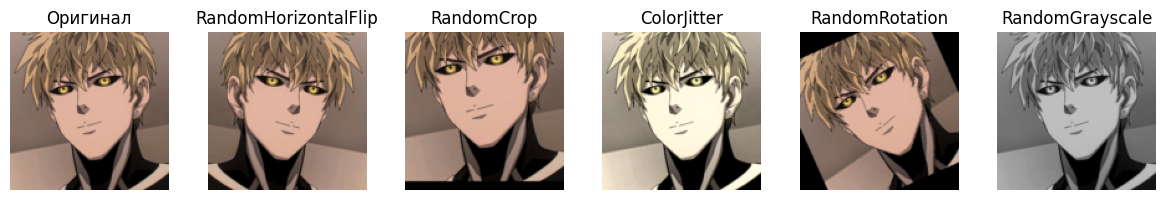

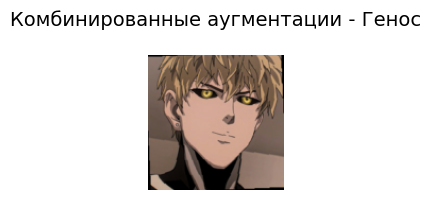


Класс: Фубуки


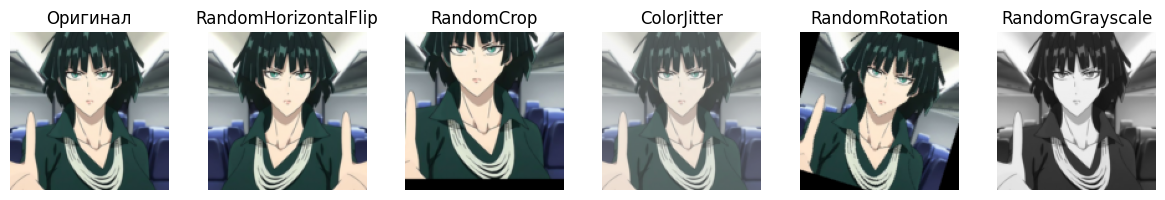

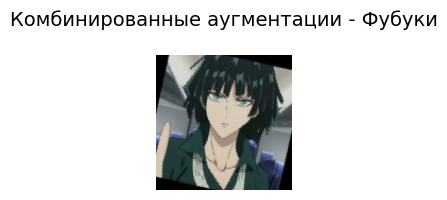


Класс: Татсумаки


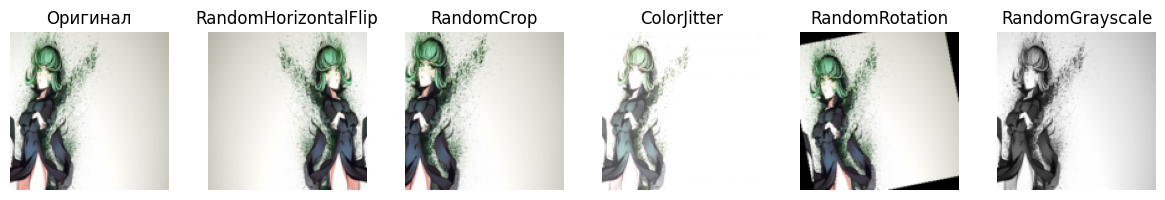

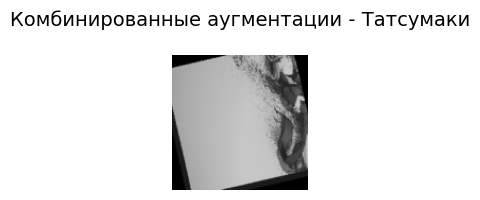


Класс: Соник


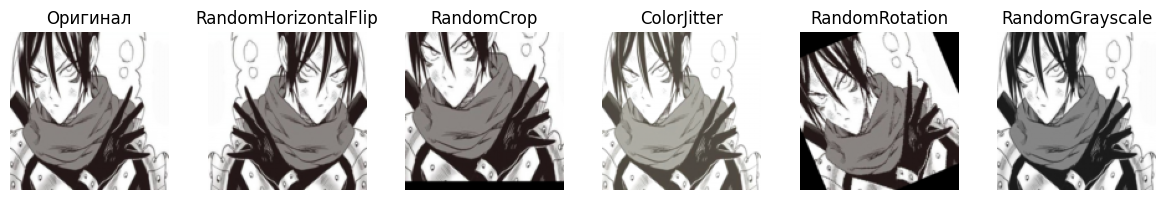

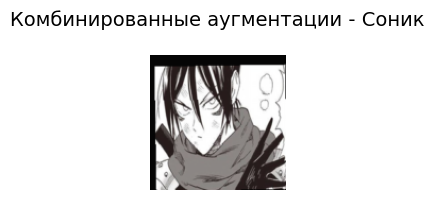


Класс: Гароу


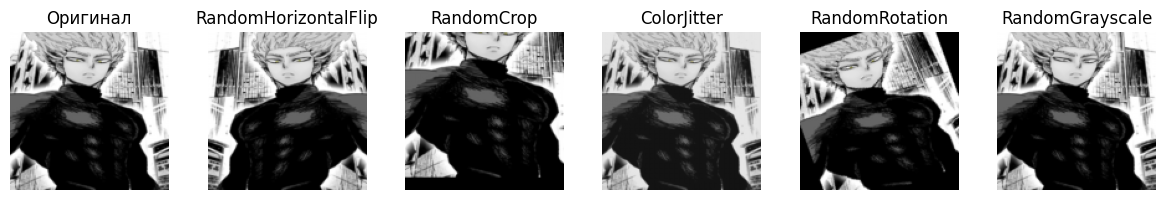

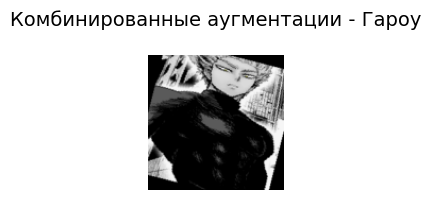

In [63]:
# Путь к данным
root = r'D:\\УЧЕБА_УРФУ\\Программирование\\4_семестр\\Практика\\data\\dataset\\train'

# Загрузка датасета без аугментаций
dataset = CustomImageDataset(root_dir=root, transform=None, target_size=(224, 224))
class_names = dataset.get_class_names()

num_classes_to_show = 5 #выберем по одному случайному изображению из 5 случайных классов
selected_classes = random.sample(range(len(class_names)), num_classes_to_show)
selected_indices = []

for cls in selected_classes:
    # Получаем индексы всех изображений данного класса
    cls_indices = [i for i, label in enumerate(dataset.labels) if label == cls]
    selected_index = random.choice(cls_indices)
    selected_indices.append(selected_index)

# Функция для применения и отображения аугментаций
def apply_and_show_augmentations(indices):
    standard_augs = [
        ("RandomHorizontalFlip", transforms.RandomHorizontalFlip(p=1.0)),
        ("RandomCrop", transforms.RandomCrop(200, padding=20)),
        ("ColorJitter", transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)),
        ("RandomRotation", transforms.RandomRotation(degrees=30)),
        ("RandomGrayscale", transforms.RandomGrayscale(p=1.0))
    ]

    combined_aug = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(200, padding=20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(degrees=15),
        transforms.RandomGrayscale(p=0.2)
    ])

    for idx in indices:
        original_img, label = dataset[idx]
        print(f"\nКласс: {class_names[label]}")
        
        to_tensor = transforms.ToTensor()#преобразуем оригинальное изображение в тензор
        original_tensor = to_tensor(original_img)

        # Отдельные аугментации
        augmented_imgs = []
        titles = []

        for name, aug in standard_augs:
            aug_transform = transforms.Compose([
                aug,
                transforms.ToTensor()
            ])
            aug_img = aug_transform(original_img)
            augmented_imgs.append(aug_img)
            titles.append(name)

        show_multiple_augmentations(original_tensor, augmented_imgs, titles)

        # Комбинированная аугментация
        # to_tensor = transforms.ToTensor()
        # original_tensor = to_tensor(original_img)
        combined_imgs = [combined_aug(original_tensor)]
        show_images(combined_imgs, title=f"Комбинированные аугментации - {class_names[label]}", nrow=1)

# Запуск функции
apply_and_show_augmentations(selected_indices)

# Итог по заданию 1
В общем, удалось применить для 5 различных классов применить 6 аугментаций по отдельности, а также применить их всех в 1-одном изображении 

# Задание 2: Кастомные аугментации

Мои собственные аугментации 

In [105]:
class RandomBrightness():# рандомная яркость
    def __init__(self, factor=None):
        if factor:
            self.factor = factor
        else:
            self.factor = random.uniform(0,1)
    def __call__(self, img):
        adjusted_img = img * self.factor
        # Обрезаем значения пикселей в диапазон [0, 1]
        brightened_img = torch.clamp(adjusted_img, 0, 1)
        return  brightened_img
    
class RandomGaussianBlur:# рандомное размытие
    def __init__(self, kernel_size_range=(3, 9), sigma_range=(0.1, 2.0)):
        self.kernel_size_range = kernel_size_range
        self.sigma_range = sigma_range

    def __call__(self, img):
        img_np = img.numpy().transpose(1, 2, 0)
        
        # Выбираем случайный размер ядра и sigma
        kernel_size = random.choice(range(self.kernel_size_range[0], self.kernel_size_range[1] + 1, 2))
        sigma = random.uniform(*self.sigma_range)
        blurred_img = cv2.GaussianBlur(img_np, (kernel_size, kernel_size), sigma)
        blurred_tensor = torch.from_numpy(blurred_img.transpose(2, 0, 1)) # Применяем гауссовский блюр
        
        return blurred_tensor
    
class RandomTransparency:# случайная прозрачность
    def __init__(self, min_alpha=0.5, max_alpha=1.0):
        
        self.min_alpha = min_alpha
        self.max_alpha = max_alpha

    def __call__(self, img):
        
        alpha = random.uniform(self.min_alpha, self.max_alpha)# Генерируем случайный коэффициент прозрачности
        transparent_img = img * alpha
        transparent_img = torch.clamp(transparent_img, 0, 1)
        
        return transparent_img

применение


Класс: Гароу


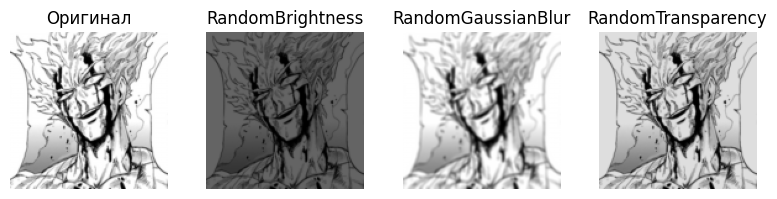

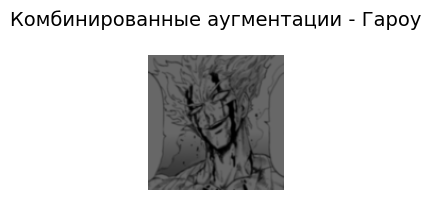


Класс: Сайтама


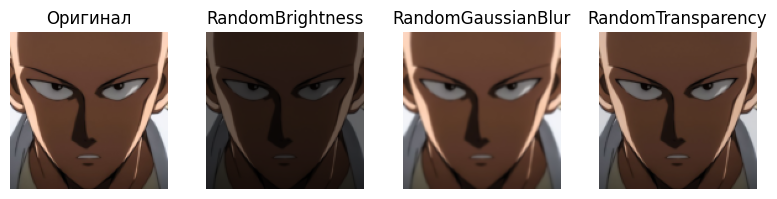

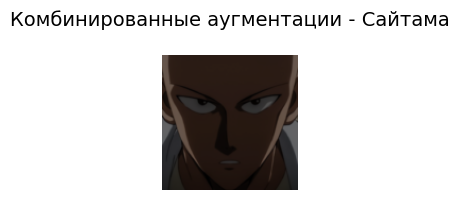


Класс: Татсумаки


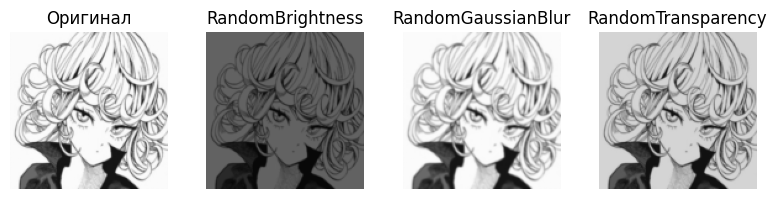

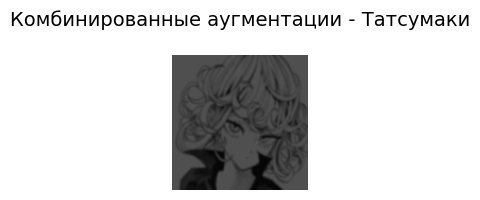


Класс: Соник


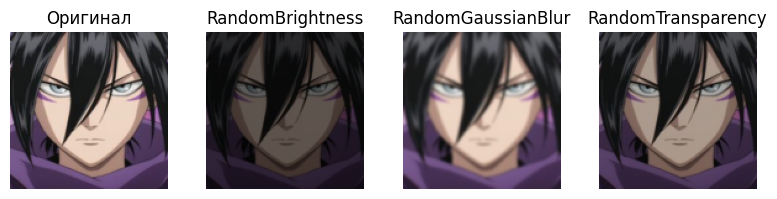

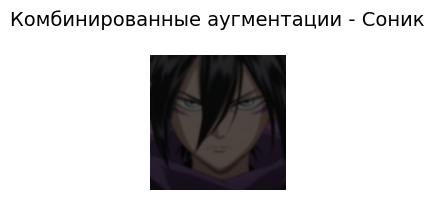


Класс: Генос


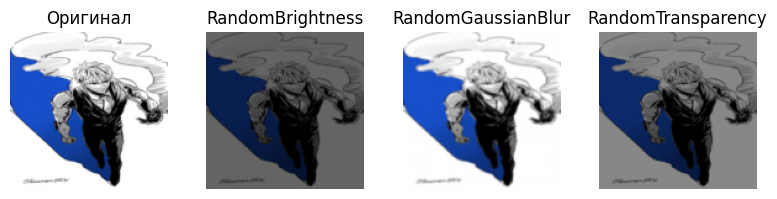

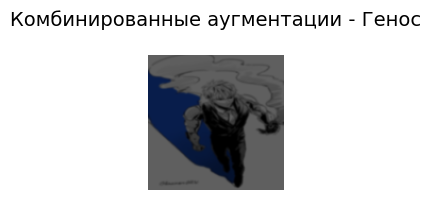

In [112]:
root = r'D:\\УЧЕБА_УРФУ\\Программирование\\4_семестр\\Практика\\data\\dataset\\train'

# Загрузка датасета без аугментаций
dataset = CustomImageDataset(root_dir=root, transform=None, target_size=(224, 224))
class_names = dataset.get_class_names()

num_classes_to_show = 5 #выберем по одному случайному изображению из 5 случайных классов
selected_classes = random.sample(range(len(class_names)), num_classes_to_show)
selected_indices = []

for cls in selected_classes:
    # Получаем индексы всех изображений данного класса
    cls_indices = [i for i, label in enumerate(dataset.labels) if label == cls]
    selected_index = random.choice(cls_indices)
    selected_indices.append(selected_index)
    
def apply_and_show_augmentations_custom(indices):
    standard_augs = [
        ("RandomBrightness", RandomBrightness()),
        ("RandomGaussianBlur", RandomGaussianBlur()),
        ("RandomTransparency", RandomTransparency())
    ]

    combined_aug = transforms.Compose([
        RandomBrightness(),
        RandomGaussianBlur(),
        RandomTransparency()
    ])

    for idx in indices:
        original_img, label = dataset[idx]
        print(f"\nКласс: {class_names[label]}")
        
        to_tensor = transforms.ToTensor()#преобразуем оригинальное изображение в тензор
        original_tensor = to_tensor(original_img)

        # Отдельные аугментации
        augmented_imgs = []
        titles = []

        for name, aug in standard_augs:
            aug_transform = transforms.Compose([
                transforms.ToTensor(),  
                aug                     
            ])
            aug_img = aug_transform(original_img)
            augmented_imgs.append(aug_img)
            titles.append(name)

        show_multiple_augmentations(original_tensor, augmented_imgs, titles)

        # Комбинированная аугментация
        # to_tensor = transforms.ToTensor()
        # original_tensor = to_tensor(original_img)
        combined_imgs = [combined_aug(original_tensor)]
        show_images(combined_imgs, title=f"Комбинированные аугментации - {class_names[label]}", nrow=1)

# Запуск функции
apply_and_show_augmentations_custom(selected_indices)

# Итог по заданию 2
Мне удалось создать свои аугментации и комбинировать их, а сравнивать с ранее испльзованными аугментациями не вижу смысла, что сравнивать, что изображения разные после эффектов своих аугментаций ? По времени тоже особой разници не заметил.   

# Задание 3: Анализ датасета 

функции для подчета размера, количества. А также визуализация полученных данных

In [125]:
from collections import defaultdict 

def count_images_per_class(root_dir):
    class_counts = defaultdict(int)
    for cls_name in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls_name)
        if os.path.isdir(cls_path):
            count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
            class_counts[cls_name] = count
    return dict(class_counts)

def get_image_sizes(root_dir):
    sizes = []
    for cls_name in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls_name)
        if os.path.isdir(cls_path):
            for img_name in os.listdir(cls_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    img_path = os.path.join(cls_path, img_name)
                    with Image.open(img_path) as img:
                        sizes.append(img.size)
    return sizes

def analyze_sizes(sizes):
    widths, heights = zip(*sizes)
    min_size = (min(widths), min(heights))
    max_size = (max(widths), max(heights))
    avg_size = (int(np.mean(widths)), int(np.mean(heights)))
    return min_size, max_size, avg_size

def visualize_analysis(class_counts, sizes):
    # Гистограмма по классам
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=45)
    plt.title("Количество изображений на класс")
    plt.ylabel("Количество")
    plt.xlabel("Класс")
    plt.tight_layout()
    plt.show()

    # Распределение размеров изображений
    widths, heights = zip(*sizes)
    plt.figure(figsize=(8, 6))
    plt.scatter(widths, heights, alpha=0.6)
    plt.title("Распределение размеров изображений (width, height)")
    plt.xlabel("Ширина")
    plt.ylabel("Высота")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


запуск 

Количество изображений на класс:
Гароу: 30
Генос: 30
Сайтама: 30
Соник: 30
Татсумаки: 30
Фубуки: 30

Сбор размеров изображений...

Минимальный размер: (210, 240)
Максимальный размер: (736, 1308)
Средний размер: (538, 623)


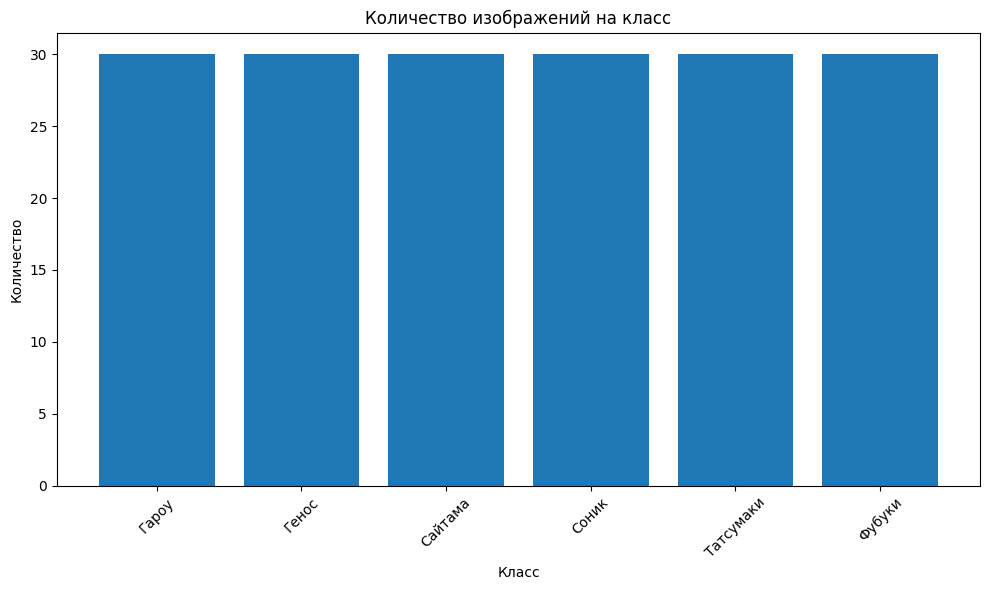

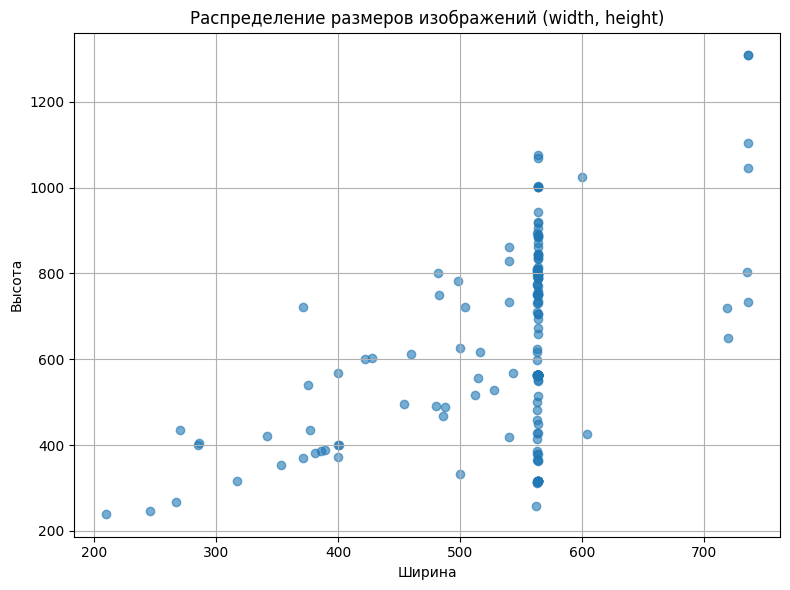

In [128]:
class_counts = count_images_per_class(root)
print("Количество изображений на класс:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")
    
print("\nСбор размеров изображений...")
image_sizes = get_image_sizes(root)

min_size, max_size, avg_size = analyze_sizes(image_sizes)
print(f"\nМинимальный размер: {min_size}")
print(f"Максимальный размер: {max_size}")
print(f"Средний размер: {avg_size}")

visualize_analysis(class_counts, image_sizes)

# Итог задание 3
По распределению количества изображения у каждого класса можно понять, что абсолютно все классы имеют одинаковое количестов изображений.
А вот по распределению размеров изображения все интереснее. Можно заметить, что большинство изображений имеют одинаковую ширину (это где-то 550-570px), а высота почти у каждой картинки максимально разные (есть конечно совпадения, но их количество мало) 


# Задание 4: Pipeline аугментаций

In [139]:
class AugmentationPipeline:
    def __init__(self):
        self.aug_dict = {}

    def add_augmentation(self, name, aug):
        # Добавляет аугментацию под указанным именем
        self.aug_dict[name] = aug

    def remove_augmentation(self, name):
        # Удаляет аугментацию по имени
        if name in self.aug_dict:
            del self.aug_dict[name]

    def apply(self, image):
        # Применяет все аугментации к изображению
        for aug in self.aug_dict.values():
            image = aug(image)
        return image

    def get_augmentations(self):
        # Возвращает список имён доступных аугментаций
        return list(self.aug_dict.keys())

Создаём конфигурации аугментаций

In [142]:
def create_augmentation_config(config_name):
    # Возвращаем готовый AugmentationPipeline в зависимости от конфигурации
    pipeline = AugmentationPipeline()

    if config_name == "light":
        pipeline.add_augmentation("ToTensor", transforms.ToTensor())
        pipeline.add_augmentation("RandomHorizontalFlip", transforms.RandomHorizontalFlip(p=0.5))
        pipeline.add_augmentation("ColorJitter", transforms.ColorJitter(brightness=0.2, contrast=0.2))

    elif config_name == "medium":
        pipeline.add_augmentation("ToTensor", transforms.ToTensor())
        pipeline.add_augmentation("RandomHorizontalFlip", transforms.RandomHorizontalFlip(p=0.5))
        pipeline.add_augmentation("RandomCrop", transforms.RandomCrop(200, padding=20))
        pipeline.add_augmentation("ColorJitter", transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3))
        pipeline.add_augmentation("RandomGrayscale", transforms.RandomGrayscale(p=0.2))

    elif config_name == "heavy":
        pipeline.add_augmentation("ToTensor", transforms.ToTensor())
        pipeline.add_augmentation("RandomHorizontalFlip", transforms.RandomHorizontalFlip(p=0.5))
        pipeline.add_augmentation("RandomCrop", transforms.RandomCrop(200, padding=20))
        pipeline.add_augmentation("ColorJitter", transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1))
        pipeline.add_augmentation("RandomGrayscale", transforms.RandomGrayscale(p=0.3))
        pipeline.add_augmentation("AddGaussianNoise", AddGaussianNoise(0., 0.1))
        pipeline.add_augmentation("CutOut", CutOut(p=0.5, size=(32, 32)))
        pipeline.add_augmentation("ElasticTransform", ElasticTransform(p=0.3, alpha=1, sigma=50))

    return pipeline

Создам также функцию для применения аугментации 

In [150]:
def apply_pipeline_to_dataset(dataset, pipeline, output_dir):
    
    os.makedirs(output_dir, exist_ok=True)

    for idx in range(len(dataset)):
        img_path = dataset.images[idx]
        class_name = dataset.get_class_names()[dataset.labels[idx]]
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        
        filename = os.path.basename(img_path)
        base, ext = os.path.splitext(filename)
        out_filename = f"{base}_aug{ext}"
        out_path = os.path.join(class_dir, out_filename)
        
        image = Image.open(img_path).convert('RGB')# Загружаем конвертируем в виде RGB и применяем аугментации
        augmented_image = pipeline.apply(image)

        if isinstance(augmented_image, torch.Tensor):# Сохраняем результат
            augmented_image = transforms.ToPILImage()(augmented_image)

        augmented_image.save(out_path)

Применение функций

In [157]:
root = r'D:\УЧЕБА_УРФУ\Программирование\4_семестр\Практика\data\dataset\train'

dataset = CustomImageDataset(root_dir=root, transform=None, target_size=(224, 224))
configs = ["light", "medium", "heavy"]

for config in configs:
    print(f"Применение конфигурации: {config}")
    pipeline = create_augmentation_config(config)
    
    print("Аугментации:", pipeline.get_augmentations()) # Показываем список аугментаций
    output_dir = os.path.join("augmented_data", config)
    apply_pipeline_to_dataset(dataset, pipeline, output_dir)

Применение конфигурации: light
Аугментации: ['ToTensor', 'RandomHorizontalFlip', 'ColorJitter']
Применение конфигурации: medium
Аугментации: ['ToTensor', 'RandomHorizontalFlip', 'RandomCrop', 'ColorJitter', 'RandomGrayscale']
Применение конфигурации: heavy
Аугментации: ['ToTensor', 'RandomHorizontalFlip', 'RandomCrop', 'ColorJitter', 'RandomGrayscale', 'AddGaussianNoise', 'CutOut', 'ElasticTransform']


# Итог задания 4
Особо сказать нечего. 
Вывод программы показывает, какие наборы аугментаций применяются в зависимости от уровня сложности (light, medium, heavy).
Это позволяет понять, насколько интенсивно изменяются изображения перед обучением модели.
Light — минимальные изменения: отражение и небольшие цветовые вариации. Подходит для базового расширения датасета.
Medium — добавляется обрезка и ЧБ преобразование. Улучшает устойчивость к разным условиям.
Heavy — самые сильные аугментации: шумы, вырезание участков, деформации. Полезно при малом количестве данных.

# Задание 5: Эксперимент с размерами

визуализация 

In [162]:
def visual_time_memory(sizes_labels):
    plt.figure(figsize=(12, 5))

    # График времени
    plt.subplot(1, 2, 1)
    plt.plot(sizes_labels, times, marker='o')
    plt.title("Время обработки 100 изображений")
    plt.xlabel("Размер изображения")
    plt.ylabel("Время (секунды)")

    # График памяти
    plt.subplot(1, 2, 2)
    plt.plot(sizes_labels, memories, marker='o', color='r')
    plt.title("Пиковая память при обработке")
    plt.xlabel("Размер изображения")
    plt.ylabel("Память (KB)")

    plt.tight_layout()
    plt.show()

Функция для замера времени и памяти

In [181]:
def benchmark_size(root_dir,target_size):
    print(f"\nТестирование размера: {target_size}")
    
    
    dataset = CustomImageDataset(
        root_dir=root_dir,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            AddGaussianNoise(0., 0.1)
        ]),
        target_size=target_size
    )

    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    start_time = time.time()
    tracemalloc.start()

    for i, (images, _) in enumerate(dataloader):
        if i >= num_images:
            break

    elapsed_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print(f"Время: {elapsed_time:.2f} сек")
    print(f"Пиковая память: {peak / 1024:.2f} KB")

    return elapsed_time, peak / 1024  # возвращаем время и память в KB



выполнение эксперемента


Тестирование размера: (64, 64)
Время: 2.55 сек
Пиковая память: 299.12 KB

Тестирование размера: (128, 128)
Время: 2.69 сек
Пиковая память: 295.76 KB

Тестирование размера: (224, 224)
Время: 3.77 сек
Пиковая память: 453.47 KB

Тестирование размера: (512, 512)
Время: 6.55 сек
Пиковая память: 1696.87 KB


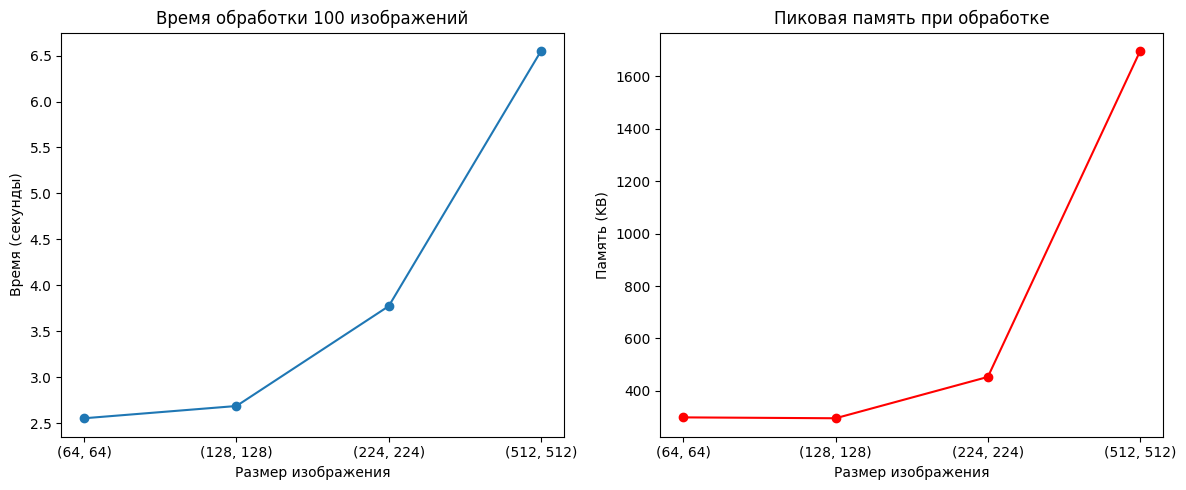

In [186]:
image_sizes = [(64, 64), (128, 128), (224, 224), (512, 512)]
num_images = 100  # Количество изображений для тестирования
root = 'D:\\УЧЕБА_УРФУ\\Программирование\\4_семестр\\Практика\\data\\dataset\\train'

times = []
memories = []
sizes_labels = [str(size) for size in image_sizes]

for size in image_sizes:
    elapsed_time, memory_peak = benchmark_size(root, size)
    times.append(elapsed_time)
    memories.append(memory_peak)

visual_time_memory(sizes_labels)

# Итог задания 5
В общем можно было ожидать, что от увеличения мастштаба изображения будет увеличиваться и размер использованной памяти и время выполнения. 

# Задание 6: Дообучение предобученных моделей 

Подготовка параметров и данных для обучения

In [207]:
MODEL_NAME = 'resnet18' 
EPOCHS = 10
BATCH_SIZE = 32
LR = 1e-3
IMAGE_SIZE = (224, 224)

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])
root = 'D:\\УЧЕБА_УРФУ\\Программирование\\4_семестр\\Практика\\data\\dataset\\train'

train_dataset = CustomImageDataset(root_dir=root, transform=transform)
val_dataset = CustomImageDataset(root_dir=root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

class_names = train_dataset.get_class_names()
num_classes = len(class_names)
print(f"Классы: {class_names} | Всего классов: {num_classes}")

model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()



Классы: ['Гароу', 'Генос', 'Сайтама', 'Соник', 'Татсумаки', 'Фубуки'] | Всего классов: 6


Обучение с валидацией

In [209]:
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    print(f"\nЭпоха {epoch + 1}/{EPOCHS}")
    
    #Тренировка
    model.train()
    train_loss, train_correct, train_total = 0., 0, 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = out.max(1)
        train_correct += (predicted == y).sum().item()
        train_total += y.size(0)

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(train_correct / train_total)

    # Тестирование
    model.eval()
    val_loss, val_correct, val_total = 0., 0, 0
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)

            val_loss += loss.item()
            _, predicted = out.max(1)
            val_correct += (predicted == y).sum().item()
            val_total += y.size(0)

    history['val_loss'].append(val_loss / len(val_loader))
    history['val_acc'].append(val_correct / val_total)

    print(f"Train Loss: {history['train_loss'][-1]:.4f}, Train Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val   Loss: {history['val_loss'][-1]:.4f}, Val   Acc: {history['val_acc'][-1]:.4f}")


Эпоха 1/10
Train Loss: 1.0907, Train Acc: 0.5889
Val   Loss: 1.0690, Val   Acc: 0.6889

Эпоха 2/10
Train Loss: 0.2202, Train Acc: 0.9333
Val   Loss: 0.6989, Val   Acc: 0.9000

Эпоха 3/10
Train Loss: 0.0755, Train Acc: 0.9778
Val   Loss: 0.5552, Val   Acc: 0.9278

Эпоха 4/10
Train Loss: 0.1942, Train Acc: 0.9556
Val   Loss: 0.0506, Val   Acc: 0.9889

Эпоха 5/10
Train Loss: 0.2575, Train Acc: 0.9389
Val   Loss: 1.1121, Val   Acc: 0.8333

Эпоха 6/10
Train Loss: 0.1120, Train Acc: 0.9667
Val   Loss: 2.5612, Val   Acc: 0.6778

Эпоха 7/10
Train Loss: 0.1918, Train Acc: 0.9389
Val   Loss: 0.3120, Val   Acc: 0.9056

Эпоха 8/10
Train Loss: 0.1026, Train Acc: 0.9722
Val   Loss: 0.1795, Val   Acc: 0.9444

Эпоха 9/10
Train Loss: 0.1638, Train Acc: 0.9389
Val   Loss: 0.0988, Val   Acc: 0.9667

Эпоха 10/10
Train Loss: 0.1077, Train Acc: 0.9611
Val   Loss: 0.0939, Val   Acc: 0.9611


Визуализация обучения

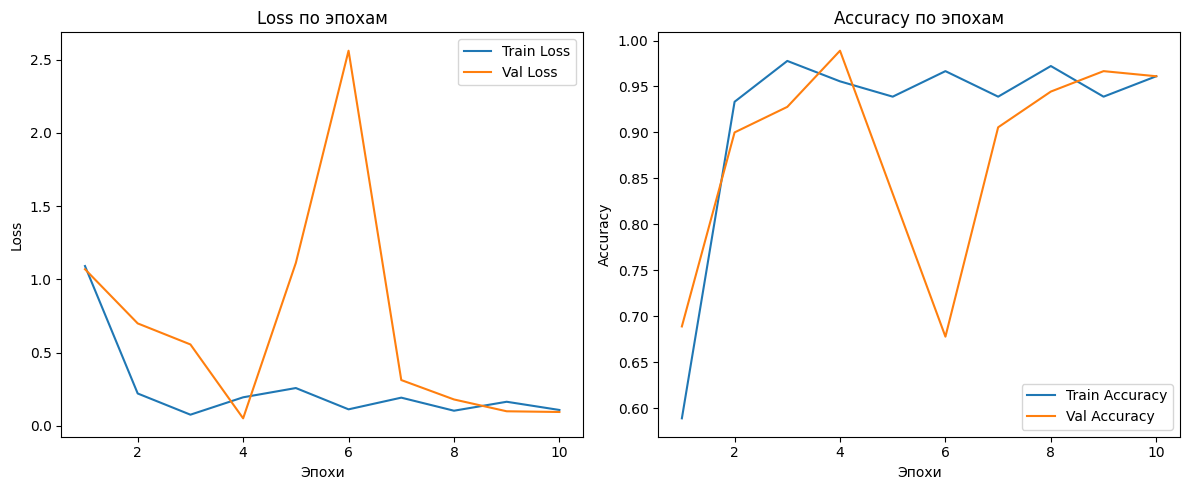

In [212]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# График лосса
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'], label='Val Loss')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('Loss по эпохам')
plt.legend()

# График accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Val Accuracy')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.title('Accuracy по эпохам')
plt.legend()

plt.tight_layout()
plt.show()

# Итог задания 6
Судя по графикам модель, которую я выбрал (resnet18), показывает хорошие более результаты. Однако есть беспокойство, например на эпохе 4, и особенно на 6 можно заметить гигантские скачки, что ухудшают результаты. Главное то, что к концу обучения все показатели становятся лучше, даже слишком, так как loss и accuracy тестового этапа становится лучше тренировачных, что может говорить о возможном переобучении. К счастью вроде в 10-ой эпохе стало все приходить в норму 